## Model Training

In [ ]:
import math
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor, plot_tree  # pip install xgboost
import optuna
from matplotlib import pyplot as plt
import seaborn as sns
from eclyon.transforms import process_df

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('cleaned_restaurant_inspection_data_3.csv')
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,...,Census Tract,BIN,BBL,NTA,Location,days_since_last,avg_last_3_scores,inspection_year,inspection_month,inspection_weekday
0,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,06D,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),730.0,25.02185,2023,1,1
1,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,08C,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1
2,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,04L,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1
3,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,06C,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1
4,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,10F,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1


In [5]:
X, y, nas = process_df(df, y_field = 'SCORE')

In [6]:
pd.concat([X.head(), X.tail()])

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,...,inspection_month,inspection_weekday,ZIPCODE_na,Latitude_na,Longitude_na,Community Board_na,Council District_na,Census Tract_na,BIN_na,BBL_na
0,30075445,12616,1,37,1539,10462.0,2680,8,1,43,...,1,1,False,False,False,False,False,False,False,False
1,30075445,12616,1,37,1539,10462.0,2680,8,1,52,...,1,1,False,False,False,False,False,False,False,False
2,30075445,12616,1,37,1539,10462.0,2680,8,1,27,...,1,1,False,False,False,False,False,False,False,False
3,30075445,12616,1,37,1539,10462.0,2680,8,1,42,...,1,1,False,False,False,False,False,False,False,False
4,30075445,12616,1,37,1539,10462.0,2680,8,1,63,...,1,1,False,False,False,False,False,False,False,False
275284,50178121,5420,3,2065,839,10013.0,22895,8,5,63,...,10,2,False,False,False,False,False,False,False,False
275285,50178178,8261,2,5403,220,11220.0,24256,64,5,63,...,10,0,False,False,False,False,False,False,False,False
275286,50178178,8261,2,5403,220,11220.0,24256,64,5,64,...,10,0,False,False,False,False,False,False,False,False
275287,50178190,1678,2,4657,1627,11216.0,10685,23,5,42,...,11,0,False,False,False,False,False,False,False,False
275288,50178194,1407,2,6682,164,11209.0,22697,7,5,63,...,10,0,False,False,False,False,False,False,False,False


### Divide the training set and the test set

In [7]:
n_total = len(df)
print('full number of data points : {}'.format(n_total))

full number of data points : 275289


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("validation set size:", X_valid.shape)

Training set size: (220231, 35)
validation set size: (55058, 35)


### 1. The random forest model

In [9]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [10]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [ ]:
model_1 = RandomForestRegressor(
    n_estimators = 800, 
    criterion = 'squared_error', 
    
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    max_features = 0.5, 
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    warm_start = False, 
    n_jobs = -1,
    random_state = 42,
    verbose = 0, 
)

model_1.fit(X_train, y_train)
print_score(model_1, X_train, y_train, X_valid, y_valid)

RMSE on train set: 6.8830
RMSE on valid set: 8.3262
R^2 on train set: 0.8651
R^2 on valid set: 0.8057
R^2 on oob set: 0.8073


In [ ]:
model_2 = RandomForestRegressor(
    n_estimators = 500, 
    criterion = 'squared_error', 
    
    max_depth = 12,
    min_samples_split = 20, 
    min_samples_leaf = 10,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    max_features = 0.5, 
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    warm_start = False, 
    n_jobs = -1,
    random_state = 42,
    verbose = 0, 
)

model_2.fit(X_train, y_train)
print_score(model_2, X_train, y_train, X_valid, y_valid)

RMSE on train set: 7.9641
RMSE on valid set: 8.4430
R^2 on train set: 0.8194
R^2 on valid set: 0.8002
R^2 on oob set: 0.8025


Use Optuna

In [11]:
def objective_rf(trial, X_train, y_train, X_val, y_val):
   
    params = {
        'n_estimators': 500,  
        'criterion': 'squared_error',

        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    r2 = metrics.r2_score(y_val, preds)
    return r2

In [12]:
study = optuna.create_study(study_name="random_forest",
                            direction="maximize")

study.optimize(lambda trial: objective_rf(trial, X_train, y_train, X_valid, y_valid), n_trials=30)

[I 2025-11-30 14:25:56,267] A new study created in memory with name: random_forest
[I 2025-11-30 14:27:51,514] Trial 0 finished with value: 0.7941191249680366 and parameters: {'max_depth': 15, 'min_samples_leaf': 58, 'max_features': 0.8047545313970451, 'max_samples': 0.62362460658444}. Best is trial 0 with value: 0.7941191249680366.
[I 2025-11-30 14:31:13,843] Trial 1 finished with value: 0.7969676945795711 and parameters: {'max_depth': 22, 'min_samples_leaf': 41, 'max_features': 0.7714582607862943, 'max_samples': 0.7178019913682578}. Best is trial 1 with value: 0.7969676945795711.
[I 2025-11-30 14:32:03,815] Trial 2 finished with value: 0.7443770117686362 and parameters: {'max_depth': 20, 'min_samples_leaf': 60, 'max_features': 0.18425903087532944, 'max_samples': 0.8036497727178851}. Best is trial 1 with value: 0.7969676945795711.
[I 2025-11-30 14:32:45,202] Trial 3 finished with value: 0.7600000365564543 and parameters: {'max_depth': 26, 'min_samples_leaf': 25, 'max_features': 0.1858

In [13]:
print("optimal parameter:", study.best_params)
print("optimal score", study.best_value)

optimal parameter: {'max_depth': 25, 'min_samples_leaf': 1, 'max_features': 0.3503472581846072, 'max_samples': 0.8710629609850852}
optimal score 0.8072450463071644


In [16]:
model_3 = RandomForestRegressor(
    n_estimators = 500, 
    criterion = 'squared_error', 
    
    # stoping criteria
    max_depth = 25,
    min_samples_leaf = 1,
 
    # bagging parameters
    max_features = 0.35, 
    max_samples = 0.87,
    
    # other
    n_jobs = -1,
    random_state = 42,
)

model_3.fit(X_train, y_train)
print_score(model_3, X_train, y_train, X_valid, y_valid)

RMSE on train set: 4.0789
RMSE on valid set: 8.2944
R^2 on train set: 0.9526
R^2 on valid set: 0.8072


we find in random forest model, `model_2` has best **$R^2$**: 0.805

### 2. XG boost model

In [23]:
def reg_perf(regressor, X_training, X_validation, y_true_training, y_true_validation, plot=True):
   
    y_pred_training = regressor.predict(X_training)
    y_pred_validation = regressor.predict(X_validation)
    rmse_training = metrics.root_mean_squared_error(y_true_training, y_pred_training)
    rmse_validation = metrics.root_mean_squared_error(y_true_validation, y_pred_validation)
    r2_training = metrics.r2_score(y_true_training, y_pred_training)
    r2_validation = metrics.r2_score(y_true_validation, y_pred_validation)
    print("RMSE on training set : {:.3f}".format(rmse_training))
    print("RMSE on validation set : {:.3f}".format(rmse_validation))
    print("R^2 on training set : {:.3f}".format(r2_training))
    print("R^2 on validation set : {:.3f}".format(r2_validation))

    if plot:
        sns.regplot(x=y_true_validation, y=y_pred_validation,  scatter_kws={'s': 1, 'alpha':0.7})
        plt.xlabel("true target variable")
        plt.ylabel("predicted target variable")
        plt.title("Regressor prediction vs truth on validation set")
        plt.show()

In [20]:
def objective_xgb(trial, X_train, y_train, X_val, y_val):

    params = {
        'n_estimators': 3000,  
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist',
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 20.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 20.0, log=True),
    }
    
    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False 
    )
    
    preds = model.predict(X_val)
    r2 = metrics.r2_score(y_val, preds)
    
    return r2

In [21]:
study_xgb = optuna.create_study(study_name="xg_boost", 
                                direction="maximize")
study_xgb.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_valid, y_valid), n_trials=50)

[I 2025-11-30 15:51:21,760] A new study created in memory with name: xg_boost
[I 2025-11-30 15:51:43,118] Trial 0 finished with value: 0.8309357366375634 and parameters: {'learning_rate': 0.13883304082550177, 'max_depth': 8, 'min_child_weight': 53, 'subsample': 0.9903681711600314, 'colsample_bytree': 0.866114263104769, 'reg_lambda': 0.1766832302033747, 'reg_alpha': 1.7212560949861964}. Best is trial 0 with value: 0.8309357366375634.
[I 2025-11-30 15:52:17,117] Trial 1 finished with value: 0.831530830286308 and parameters: {'learning_rate': 0.1526841801933776, 'max_depth': 10, 'min_child_weight': 34, 'subsample': 0.690169682087822, 'colsample_bytree': 0.840024053954674, 'reg_lambda': 1.2687373147766445, 'reg_alpha': 1.6198805581968123}. Best is trial 1 with value: 0.831530830286308.
[I 2025-11-30 15:52:33,682] Trial 2 finished with value: 0.8158334259682829 and parameters: {'learning_rate': 0.10503377911366367, 'max_depth': 6, 'min_child_weight': 82, 'subsample': 0.768469432210988, 'col

In [22]:
print("optimal parameter:", study_xgb.best_params)
print("optional score:", study_xgb.best_value)

optimal parameter: {'learning_rate': 0.11150917215303441, 'max_depth': 10, 'min_child_weight': 47, 'subsample': 0.8322722393835251, 'colsample_bytree': 0.5150424539541093, 'reg_lambda': 1.1080900798946567, 'reg_alpha': 1.0840465968662536}
optional score: 0.8383562236056524


RMSE on training set : 5.256
RMSE on validation set : 8.091
R^2 on training set : 0.921
R^2 on validation set : 0.816


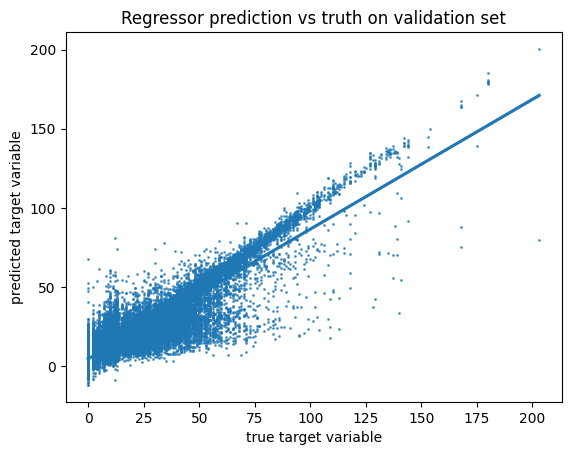

In [29]:
model_xg_1 = XGBRegressor(
    n_estimators = 800,  
    objective = 'reg:squarederror',
    n_jobs = -1,
    random_state = 42,
    tree_method = 'hist',            
    learning_rate = 0.11150917215303441, 
    max_depth = 10, 
    min_child_weight = 47, 
    subsample = 0.5322722393835251, 
    colsample_bytree = 0.5150424539541093, 
    reg_lambda = 5.1080900798946567,
    reg_alpha = 3.0840465968662536
)

model_xg_1.fit(X_train, y_train)
reg_perf(model_xg_1, X_train, X_valid, y_train, y_valid, plot=True)

In [30]:
trees = model_2.estimators_
point = [X_valid.iloc[0, :]]
preds = np.asarray([tree.predict(point) for tree in trees])
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid) for tree in model_2.estimators_]) # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds[:,0], model_2.predict(point)[0], np.mean(preds[:,0]), y_valid[0]

(array([23.88726246, 21.4970297 , 18.14531549, 20.2       , 18.06026916,
        15.99521531, 22.51387119, 19.30511464, 19.80938265, 19.63104839,
        20.6358209 , 17.97988506, 19.68622281, 20.51563188, 18.23205742,
        20.81451314, 18.41278539, 17.85968028, 21.00427716, 21.22727273,
        13.91625616, 20.04166076, 21.0195962 , 23.5597771 , 17.00408163,
        20.70626151, 21.19305857, 18.21485149, 19.57313433, 22.66177606,
        18.16666667, 19.25862069, 17.13026316, 18.19455782, 19.09201389,
        18.8891099 , 23.86031421, 17.75631769, 23.87931034, 22.0789826 ,
        16.33463035, 17.87042125, 21.23857868, 18.66340269, 20.20433129,
        19.79021792, 21.83538084, 19.01236264, 18.08695652, 21.48474576,
        21.15193305, 22.13773796, 20.98650675, 16.63858093, 15.52380952,
        19.74929871, 19.32142857, 19.70351759, 14.94295302, 19.05555556,
        20.29930687, 17.84283247, 18.68835821, 18.75893769, 14.44208038,
        18.46557377, 20.42748092, 18.27627958, 23.1

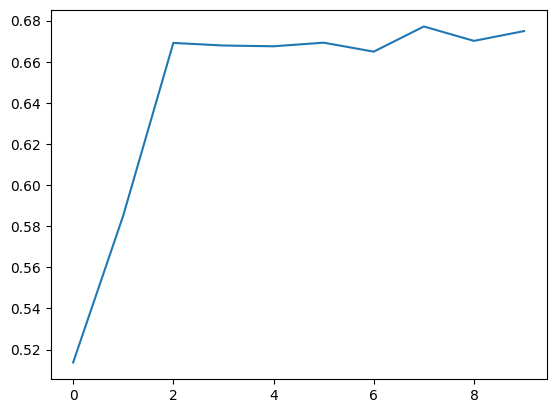

In [31]:
plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis = 0)) 
    for num_trees in range(1, 11)
])

### Feature important

The importance of built-in features

avg_last_3_scores: 0.5815
ACTION: 0.1754
days_since_last: 0.0794
VIOLATION CODE: 0.0264
INSPECTION TYPE: 0.0211
CAMIS: 0.0203
VIOLATION DESCRIPTION: 0.0146
inspection_year: 0.0124
CRITICAL FLAG: 0.0118
PHONE: 0.0054
BIN: 0.0042
BBL: 0.0038
DBA: 0.0038
inspection_month: 0.0036
Latitude: 0.0035
BUILDING: 0.0035
CUISINE DESCRIPTION: 0.0035
Longitude: 0.0033
Location: 0.0033
Census Tract: 0.0032
STREET: 0.0031
ZIPCODE: 0.0030
NTA: 0.0026
Community Board: 0.0023
inspection_weekday: 0.0022
Council District: 0.0019
BORO: 0.0004
BIN_na: 0.0000
Census Tract_na: 0.0000
Community Board_na: 0.0000
Council District_na: 0.0000
BBL_na: 0.0000
ZIPCODE_na: 0.0000
Longitude_na: 0.0000
Latitude_na: 0.0000


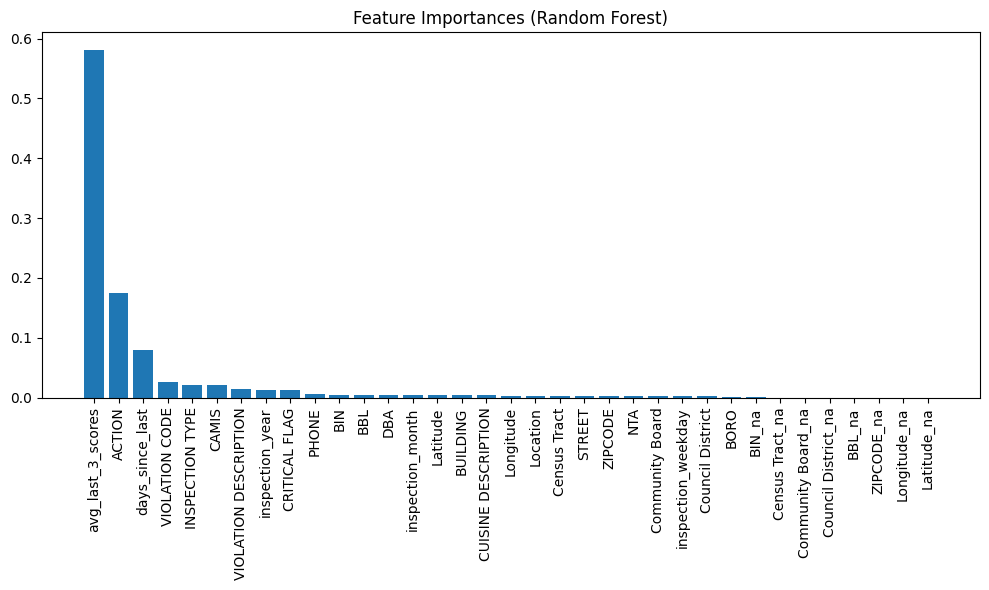

In [32]:
model_2.fit(X_train, y_train)

importances = model_2.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]:.4f}")

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

Permutation Importance

/var/folders/5y/b6cqgch533773c9dm5spwwx00000gn/T/ipykernel_87482/3557422422.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])


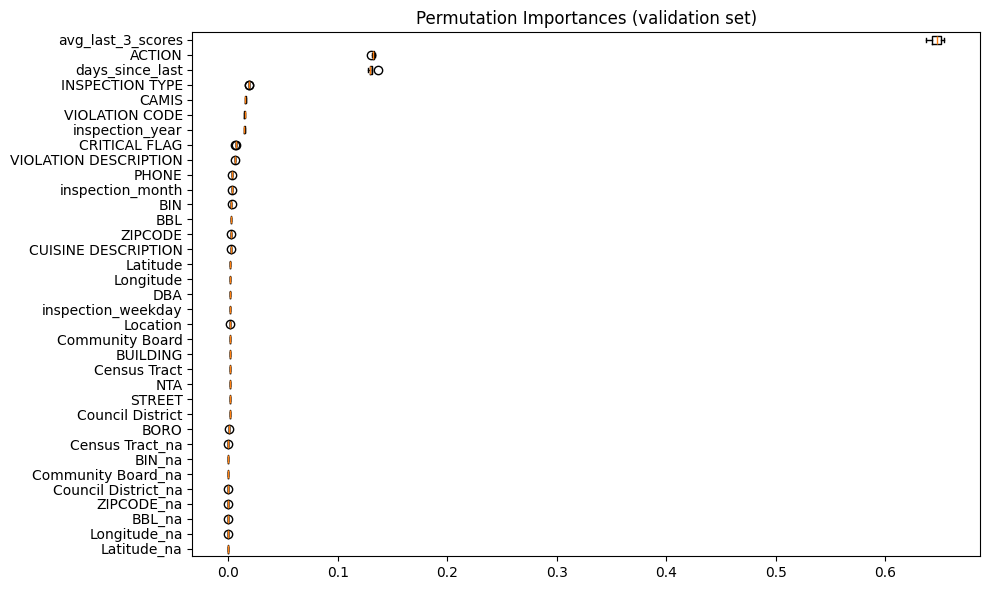

In [21]:
r = permutation_importance(model_2, X_valid, y_valid, n_repeats=10, random_state=42)

sorted_idx = r.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])
plt.title("Permutation Importances (validation set)")
plt.tight_layout()
plt.show()

In [22]:
bool_filter = r.importances_mean > 0.005
bool_filter

array([ True, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False])

the Spearman rank-order correlation matrix 

In [23]:
len(X.columns)

35

In [24]:
X.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'INSPECTION TYPE', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'BBL', 'NTA', 'Location', 'days_since_last', 'avg_last_3_scores',
       'inspection_year', 'inspection_month', 'inspection_weekday',
       'ZIPCODE_na', 'Latitude_na', 'Longitude_na', 'Community Board_na',
       'Council District_na', 'Census Tract_na', 'BIN_na', 'BBL_na'],
      dtype='object')